In [1]:
# prototype

In [9]:
import os
from os.path import join
import random
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from skimage import measure
from torch.utils.data import Dataset, DataLoader
import torchio as tio
from torchio.data import SubjectsLoader
from monai.networks.nets import UNet

from monai.networks.nets import UNet

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from pathlib import Path
from datetime import datetime

seed = 42
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)

In [10]:
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

__Python VERSION: 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:43:09) [GCC 12.3.0]
__pyTorch VERSION: 2.1.2+cu121
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0
__CUDNN VERSION: 8902
__Number CUDA Devices: 1
__Devices
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 17992 MiB, 63057 MiB
1, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 3263 MiB, 77787 MiB
2, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 3263 MiB, 77787 MiB
3, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 3263 MiB, 77787 MiB
4, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 7 MiB, 81042 MiB
5, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 7 MiB, 81042 MiB
6, NVIDIA A100-SXM4-80GB, 535.129.03, 81920 MiB, 7 MiB, 81042 MiB
7, NVIDIA A100-SXM4-80GB, 535.1

In [11]:
from utils.loading_utils import *
from utils.logging import *
from visualization.visualization import *
#from ml.dataset_ import BrainMetDatasetPreloaded, GridSamplerWrapper
from ml.dataset_ import BrainMetPytorchDataset
from ml.trainer import Trainer, load_trained_model

In [12]:
%load_ext tensorboard
%reload_ext tensorboard

%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2124630), started 0:46:57 ago. (Use '!kill 2124630' to kill it.)

In [13]:
from tensorboard import notebook
notebook.list()
#notebook.display(port=6006, height=1000)

#http://127.0.0.1:6006/?darkMode=true

Known TensorBoard instances:
  - port 6006: logdir runs (started 0:46:58 ago; pid 2124630)


In [14]:
TRAIN_ROOT_DIR  = './MICCAI-LH-BraTS2025-MET-Challenge-Training/'
HELPER_ROOT_DIR = './training_helper/'

dataset = BrainMetPytorchDataset(TRAIN_ROOT_DIR, patch_size=(128, 128, 96))
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=16, num_workers=4, shuffle=True, pin_memory=True)
validation_dataset = DataLoader(validation_dataset, batch_size=16, num_workers=4, shuffle=False, pin_memory=True)

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(
    spatial_dims=3,
    in_channels=4,
    out_channels=5,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)


def dice_loss(probs, targets, epsilon=1e-5):
    # Assumes probs: [B, C, H, W, D], targets: [B, C, H, W, D]
    intersection = (probs * targets).sum(dim=(2, 3, 4))
    union = probs.sum(dim=(2, 3, 4)) + targets.sum(dim=(2, 3, 4))
    dice = 2. * intersection / (union + epsilon)
    return 1 - dice.mean()

ce_loss = nn.CrossEntropyLoss()

def loss_fn(logits, target):
    target = target.to(torch.long)
    if target.ndim == 5 and target.shape[1] == 1:
        target = target[:, 0]              # [B, H, W, D]
    ce = torch.nn.functional.cross_entropy(logits, target)

    # --- Dice loss ---
    probs = torch.softmax(logits, dim=1)  # [B, C, H, W, D]
    one_hot_target = torch.nn.functional.one_hot(target, num_classes=logits.shape[1])  # [B, H, W, D, C]
    one_hot_target = one_hot_target.permute(0, 4, 1, 2, 3).float()    # [B, C, H, W, D]

    dice = dice_loss(probs, one_hot_target)

    return ce + dice

def dice_score(preds, targets, epsilon=1e-5):
    if targets.ndim == 5 and targets.shape[1] == 1:
        targets = targets[:, 0]  # Fix channel dim

    num_classes = int(torch.max(targets).item()) + 1
    dice_scores = []

    for c in range(num_classes):
        pred_c = (preds == c).float()
        target_c = (targets == c).float()

        intersection = (pred_c * target_c).sum(dim=(1, 2, 3))
        union = pred_c.sum(dim=(1, 2, 3)) + target_c.sum(dim=(1, 2, 3))

        dice = (2 * intersection + epsilon) / (union + epsilon)
        dice_scores.append(dice)

    return torch.stack(dice_scores).mean()




optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


Epoch: 1 [train]: 100%|██████████| 33/33 [03:37<00:00,  6.59s/it, train_loss=2.5598]

Epoch: 1 [valid]: 100%|██████████| 9/9 [01:02<00:00,  6.89s/it, valid_loss=2.3857]



Epoch Summary:
  train-loss: 2.5598
  metric-loss: 0.1877
  valid-loss: 2.3857



Epoch: 2 [train]: 100%|██████████| 33/33 [03:34<00:00,  6.51s/it, train_loss=2.2795]

Epoch: 2 [valid]: 100%|██████████| 9/9 [01:01<00:00,  6.80s/it, valid_loss=2.1797]



Epoch Summary:
  train-loss: 2.2795
  metric-loss: 0.2189
  valid-loss: 2.1797



Epoch: 3 [train]: 100%|██████████| 33/33 [03:36<00:00,  6.56s/it, train_loss=2.0833]

Epoch: 3 [valid]: 100%|██████████| 9/9 [01:04<00:00,  7.19s/it, valid_loss=1.9963]



Epoch Summary:
  train-loss: 2.0833
  metric-loss: 0.2613
  valid-loss: 1.9963



Epoch: 4 [train]: 100%|██████████| 33/33 [03:50<00:00,  6.98s/it, train_loss=1.8965]

Epoch: 4 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.24s/it, valid_loss=1.7996]



Epoch Summary:
  train-loss: 1.8965
  metric-loss: 0.2925
  valid-loss: 1.7996



Epoch: 5 [train]: 100%|██████████| 33/33 [03:46<00:00,  6.85s/it, train_loss=1.7097]

Epoch: 5 [valid]: 100%|██████████| 9/9 [00:59<00:00,  6.64s/it, valid_loss=1.6154]



Epoch Summary:
  train-loss: 1.7097
  metric-loss: 0.3054
  valid-loss: 1.6154



Epoch: 6 [train]: 100%|██████████| 33/33 [04:05<00:00,  7.45s/it, train_loss=1.5324]

Epoch: 6 [valid]: 100%|██████████| 9/9 [01:04<00:00,  7.22s/it, valid_loss=1.4525]



Epoch Summary:
  train-loss: 1.5324
  metric-loss: 0.3166
  valid-loss: 1.4525



Epoch: 7 [train]: 100%|██████████| 33/33 [03:48<00:00,  6.93s/it, train_loss=1.3682]

Epoch: 7 [valid]: 100%|██████████| 9/9 [01:06<00:00,  7.36s/it, valid_loss=1.2970]



Epoch Summary:
  train-loss: 1.3682
  metric-loss: 0.3124
  valid-loss: 1.2970



Epoch: 8 [train]: 100%|██████████| 33/33 [03:39<00:00,  6.65s/it, train_loss=1.2445]

Epoch: 8 [valid]: 100%|██████████| 9/9 [01:00<00:00,  6.67s/it, valid_loss=1.1980]



Epoch Summary:
  train-loss: 1.2445
  metric-loss: 0.3059
  valid-loss: 1.1980



Epoch: 9 [train]: 100%|██████████| 33/33 [03:33<00:00,  6.47s/it, train_loss=1.1527]

Epoch: 9 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.29s/it, valid_loss=1.1258]



Epoch Summary:
  train-loss: 1.1527
  metric-loss: 0.3460
  valid-loss: 1.1258



Epoch: 10 [train]: 100%|██████████| 33/33 [03:54<00:00,  7.10s/it, train_loss=1.0834]

Epoch: 10 [valid]: 100%|██████████| 9/9 [01:02<00:00,  6.98s/it, valid_loss=1.0617]



Epoch Summary:
  train-loss: 1.0834
  metric-loss: 0.3794
  valid-loss: 1.0617



Epoch: 11 [train]: 100%|██████████| 33/33 [03:37<00:00,  6.59s/it, train_loss=1.0321]

Epoch: 11 [valid]: 100%|██████████| 9/9 [01:03<00:00,  7.01s/it, valid_loss=1.0223]



Epoch Summary:
  train-loss: 1.0321
  metric-loss: 0.4166
  valid-loss: 1.0223



Epoch: 12 [train]: 100%|██████████| 33/33 [03:43<00:00,  6.76s/it, train_loss=0.9962]

Epoch: 12 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.28s/it, valid_loss=0.9799]



Epoch Summary:
  train-loss: 0.9962
  metric-loss: 0.4763
  valid-loss: 0.9799



Epoch: 13 [train]: 100%|██████████| 33/33 [04:24<00:00,  8.02s/it, train_loss=0.9628]

Epoch: 13 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.24s/it, valid_loss=0.9545]



Epoch Summary:
  train-loss: 0.9628
  metric-loss: 0.4105
  valid-loss: 0.9545



Epoch: 14 [train]: 100%|██████████| 33/33 [04:05<00:00,  7.44s/it, train_loss=0.9356]

Epoch: 14 [valid]: 100%|██████████| 9/9 [01:02<00:00,  6.97s/it, valid_loss=0.9309]



Epoch Summary:
  train-loss: 0.9356
  metric-loss: 0.4530
  valid-loss: 0.9309



Epoch: 15 [train]: 100%|██████████| 33/33 [04:01<00:00,  7.32s/it, train_loss=0.9148]

Epoch: 15 [valid]: 100%|██████████| 9/9 [01:04<00:00,  7.21s/it, valid_loss=0.9101]



Epoch Summary:
  train-loss: 0.9148
  metric-loss: 0.4504
  valid-loss: 0.9101



Epoch: 16 [train]: 100%|██████████| 33/33 [03:36<00:00,  6.56s/it, train_loss=0.8971]

Epoch: 16 [valid]: 100%|██████████| 9/9 [01:06<00:00,  7.34s/it, valid_loss=0.9012]



Epoch Summary:
  train-loss: 0.8971
  metric-loss: 0.4024
  valid-loss: 0.9012



Epoch: 17 [train]: 100%|██████████| 33/33 [03:34<00:00,  6.49s/it, train_loss=0.8837]

Epoch: 17 [valid]: 100%|██████████| 9/9 [01:00<00:00,  6.70s/it, valid_loss=0.8850]



Epoch Summary:
  train-loss: 0.8837
  metric-loss: 0.5142
  valid-loss: 0.8850



Epoch: 18 [train]: 100%|██████████| 33/33 [03:55<00:00,  7.13s/it, train_loss=0.8698]

Epoch: 18 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.32s/it, valid_loss=0.8717]



Epoch Summary:
  train-loss: 0.8698
  metric-loss: 0.5178
  valid-loss: 0.8717



Epoch: 19 [train]: 100%|██████████| 33/33 [03:48<00:00,  6.93s/it, train_loss=0.8594]

Epoch: 19 [valid]: 100%|██████████| 9/9 [01:02<00:00,  6.99s/it, valid_loss=0.8556]



Epoch Summary:
  train-loss: 0.8594
  metric-loss: 0.4664
  valid-loss: 0.8556



Epoch: 20 [train]: 100%|██████████| 33/33 [03:42<00:00,  6.74s/it, train_loss=0.8478]

Epoch: 20 [valid]: 100%|██████████| 9/9 [01:03<00:00,  7.00s/it, valid_loss=0.8472]



Epoch Summary:
  train-loss: 0.8478
  metric-loss: 0.4894
  valid-loss: 0.8472



Epoch: 21 [train]: 100%|██████████| 33/33 [03:50<00:00,  6.98s/it, train_loss=0.8390]

Epoch: 21 [valid]: 100%|██████████| 9/9 [01:00<00:00,  6.74s/it, valid_loss=0.8413]



Epoch Summary:
  train-loss: 0.8390
  metric-loss: 0.5195
  valid-loss: 0.8413



Epoch: 22 [train]: 100%|██████████| 33/33 [03:59<00:00,  7.26s/it, train_loss=0.8323]

Epoch: 22 [valid]: 100%|██████████| 9/9 [01:01<00:00,  6.82s/it, valid_loss=0.8376]



Epoch Summary:
  train-loss: 0.8323
  metric-loss: 0.5241
  valid-loss: 0.8376



Epoch: 23 [train]: 100%|██████████| 33/33 [03:43<00:00,  6.78s/it, train_loss=0.8202]

Epoch: 23 [valid]: 100%|██████████| 9/9 [01:01<00:00,  6.86s/it, valid_loss=0.8255]



Epoch Summary:
  train-loss: 0.8202
  metric-loss: 0.4956
  valid-loss: 0.8255



Epoch: 24 [train]: 100%|██████████| 33/33 [03:32<00:00,  6.43s/it, train_loss=0.8135]

Epoch: 24 [valid]: 100%|██████████| 9/9 [01:07<00:00,  7.47s/it, valid_loss=0.8183]



Epoch Summary:
  train-loss: 0.8135
  metric-loss: 0.4549
  valid-loss: 0.8183



Epoch: 25 [train]: 100%|██████████| 33/33 [03:59<00:00,  7.25s/it, train_loss=0.8066]

Epoch: 25 [valid]: 100%|██████████| 9/9 [01:06<00:00,  7.38s/it, valid_loss=0.8252]



Epoch Summary:
  train-loss: 0.8066
  metric-loss: 0.4562
  valid-loss: 0.8252



Epoch: 26 [train]: 100%|██████████| 33/33 [04:00<00:00,  7.27s/it, train_loss=0.8077]

Epoch: 26 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.33s/it, valid_loss=0.8176]



Epoch Summary:
  train-loss: 0.8077
  metric-loss: 0.4411
  valid-loss: 0.8176



Epoch: 27 [train]: 100%|██████████| 33/33 [04:03<00:00,  7.39s/it, train_loss=0.7985]

Epoch: 27 [valid]: 100%|██████████| 9/9 [01:02<00:00,  6.97s/it, valid_loss=0.7987]



Epoch Summary:
  train-loss: 0.7985
  metric-loss: 0.5214
  valid-loss: 0.7987



Epoch: 28 [train]: 100%|██████████| 33/33 [03:48<00:00,  6.92s/it, train_loss=0.7936]

Epoch: 28 [valid]: 100%|██████████| 9/9 [01:03<00:00,  7.04s/it, valid_loss=0.7987]



Epoch Summary:
  train-loss: 0.7936
  metric-loss: 0.5203
  valid-loss: 0.7987



Epoch: 29 [train]: 100%|██████████| 33/33 [03:34<00:00,  6.51s/it, train_loss=0.7851]

Epoch: 29 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.29s/it, valid_loss=0.7881]



Epoch Summary:
  train-loss: 0.7851
  metric-loss: 0.5133
  valid-loss: 0.7881



Epoch: 30 [train]: 100%|██████████| 33/33 [04:03<00:00,  7.37s/it, train_loss=0.7796]

Epoch: 30 [valid]: 100%|██████████| 9/9 [00:59<00:00,  6.63s/it, valid_loss=0.7898]



Epoch Summary:
  train-loss: 0.7796
  metric-loss: 0.5098
  valid-loss: 0.7898



Epoch: 31 [train]: 100%|██████████| 33/33 [04:07<00:00,  7.50s/it, train_loss=0.7760]

Epoch: 31 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.27s/it, valid_loss=0.7780]



Epoch Summary:
  train-loss: 0.7760
  metric-loss: 0.5353
  valid-loss: 0.7780



Epoch: 32 [train]: 100%|██████████| 33/33 [03:34<00:00,  6.49s/it, train_loss=0.7673]

Epoch: 32 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.33s/it, valid_loss=0.7775]



Epoch Summary:
  train-loss: 0.7673
  metric-loss: 0.5447
  valid-loss: 0.7775



Epoch: 33 [train]: 100%|██████████| 33/33 [04:04<00:00,  7.41s/it, train_loss=0.7649]

Epoch: 33 [valid]: 100%|██████████| 9/9 [01:03<00:00,  7.04s/it, valid_loss=0.7726]



Epoch Summary:
  train-loss: 0.7649
  metric-loss: 0.5506
  valid-loss: 0.7726



Epoch: 34 [train]: 100%|██████████| 33/33 [03:46<00:00,  6.86s/it, train_loss=0.7600]

Epoch: 34 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.29s/it, valid_loss=0.7717]



Epoch Summary:
  train-loss: 0.7600
  metric-loss: 0.5848
  valid-loss: 0.7717



Epoch: 35 [train]: 100%|██████████| 33/33 [03:43<00:00,  6.78s/it, train_loss=0.7558]

Epoch: 35 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.30s/it, valid_loss=0.7730]



Epoch Summary:
  train-loss: 0.7558
  metric-loss: 0.5496
  valid-loss: 0.7730



Epoch: 36 [train]: 100%|██████████| 33/33 [03:53<00:00,  7.07s/it, train_loss=0.7544]

Epoch: 36 [valid]: 100%|██████████| 9/9 [01:03<00:00,  7.00s/it, valid_loss=0.7643]



Epoch Summary:
  train-loss: 0.7544
  metric-loss: 0.5730
  valid-loss: 0.7643



Epoch: 37 [train]: 100%|██████████| 33/33 [04:03<00:00,  7.38s/it, train_loss=0.7475]

Epoch: 37 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.24s/it, valid_loss=0.7598]



Epoch Summary:
  train-loss: 0.7475
  metric-loss: 0.5701
  valid-loss: 0.7598



Epoch: 38 [train]: 100%|██████████| 33/33 [03:54<00:00,  7.11s/it, train_loss=0.7443]

Epoch: 38 [valid]: 100%|██████████| 9/9 [01:00<00:00,  6.73s/it, valid_loss=0.7598]



Epoch Summary:
  train-loss: 0.7443
  metric-loss: 0.5517
  valid-loss: 0.7598



Epoch: 39 [train]: 100%|██████████| 33/33 [03:46<00:00,  6.87s/it, train_loss=0.7398]

Epoch: 39 [valid]: 100%|██████████| 9/9 [01:04<00:00,  7.18s/it, valid_loss=0.7584]



Epoch Summary:
  train-loss: 0.7398
  metric-loss: 0.5432
  valid-loss: 0.7584



Epoch: 40 [train]: 100%|██████████| 33/33 [03:39<00:00,  6.65s/it, train_loss=0.7318]

Epoch: 40 [valid]: 100%|██████████| 9/9 [01:06<00:00,  7.42s/it, valid_loss=0.7536]



Epoch Summary:
  train-loss: 0.7318
  metric-loss: 0.5657
  valid-loss: 0.7536



Epoch: 41 [train]: 100%|██████████| 33/33 [04:05<00:00,  7.43s/it, train_loss=0.7319]

Epoch: 41 [valid]: 100%|██████████| 9/9 [01:02<00:00,  6.92s/it, valid_loss=0.7428]



Epoch Summary:
  train-loss: 0.7319
  metric-loss: 0.5632
  valid-loss: 0.7428



Epoch: 42 [train]: 100%|██████████| 33/33 [03:36<00:00,  6.57s/it, train_loss=0.7257]

Epoch: 42 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.32s/it, valid_loss=0.7501]



Epoch Summary:
  train-loss: 0.7257
  metric-loss: 0.5598
  valid-loss: 0.7501



Epoch: 43 [train]: 100%|██████████| 33/33 [04:05<00:00,  7.43s/it, train_loss=0.7229]

Epoch: 43 [valid]: 100%|██████████| 9/9 [00:59<00:00,  6.65s/it, valid_loss=0.7391]



Epoch Summary:
  train-loss: 0.7229
  metric-loss: 0.5497
  valid-loss: 0.7391



Epoch: 44 [train]: 100%|██████████| 33/33 [03:51<00:00,  7.02s/it, train_loss=0.7206]

Epoch: 44 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.31s/it, valid_loss=0.7425]



Epoch Summary:
  train-loss: 0.7206
  metric-loss: 0.5850
  valid-loss: 0.7425



Epoch: 45 [train]: 100%|██████████| 33/33 [03:51<00:00,  7.01s/it, train_loss=0.7171]

Epoch: 45 [valid]: 100%|██████████| 9/9 [01:01<00:00,  6.89s/it, valid_loss=0.7441]



Epoch Summary:
  train-loss: 0.7171
  metric-loss: 0.5954
  valid-loss: 0.7441



Epoch: 46 [train]: 100%|██████████| 33/33 [03:32<00:00,  6.44s/it, train_loss=0.7177]

Epoch: 46 [valid]: 100%|██████████| 9/9 [01:05<00:00,  7.30s/it, valid_loss=0.7316]



Epoch Summary:
  train-loss: 0.7177
  metric-loss: 0.5646
  valid-loss: 0.7316



Epoch: 47 [train]: 100%|██████████| 33/33 [03:51<00:00,  7.03s/it, train_loss=0.7163]

Epoch: 47 [valid]: 100%|██████████| 9/9 [01:02<00:00,  6.92s/it, valid_loss=0.7279]



Epoch Summary:
  train-loss: 0.7163
  metric-loss: 0.5914
  valid-loss: 0.7279



Epoch: 48 [train]: 100%|██████████| 33/33 [03:48<00:00,  6.93s/it, train_loss=0.7109]

Epoch: 48 [valid]: 100%|██████████| 9/9 [01:00<00:00,  6.77s/it, valid_loss=0.7281]



Epoch Summary:
  train-loss: 0.7109
  metric-loss: 0.5859
  valid-loss: 0.7281



Epoch: 49 [train]: 100%|██████████| 33/33 [03:48<00:00,  6.92s/it, train_loss=0.7082]

Epoch: 49 [valid]: 100%|██████████| 9/9 [01:04<00:00,  7.19s/it, valid_loss=0.7336]



Epoch Summary:
  train-loss: 0.7082
  metric-loss: 0.5607
  valid-loss: 0.7336



Epoch: 50 [train]: 100%|██████████| 33/33 [03:38<00:00,  6.61s/it, train_loss=0.7020]

Epoch: 50 [valid]: 100%|██████████| 9/9 [01:04<00:00,  7.17s/it, valid_loss=0.7146]



Epoch Summary:
  train-loss: 0.7020
  metric-loss: 0.5696
  valid-loss: 0.7146


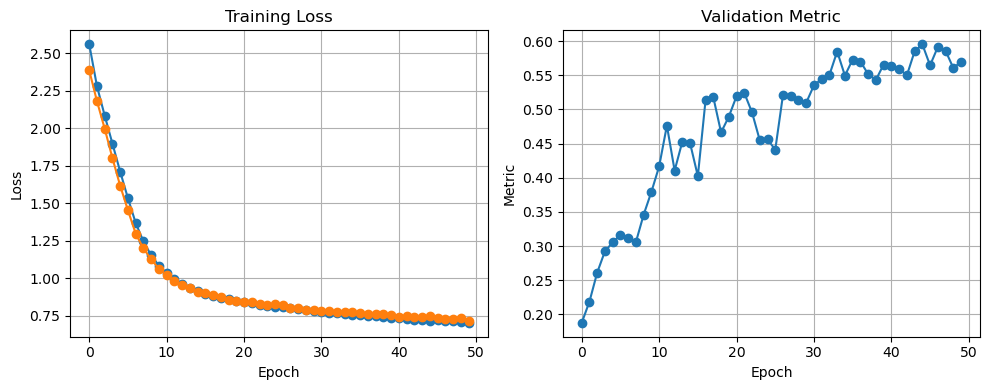

In [16]:
#train_dataloader, val_dataloader = load_data(batch_size=args.batch_size, num_workers=args.num_workers, use_torchio_version=args.use_torchio)
num_epochs = 50
dir = f'./runs/run_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}'
progress = ProgressBar()
tb = TensorBoard(path=dir)
checkpoints = Backup(path=dir, every=5)

trainer = Trainer(model, optimizer, loss_fn, dice_score, device=device, use_torchio=False)
checkpoints.attach_trainer(trainer)
trainer.tracker.loggers = [progress, tb, checkpoints]

trainer.train(train_loader=train_dataloader, val_loader=validation_dataset, epochs=num_epochs)

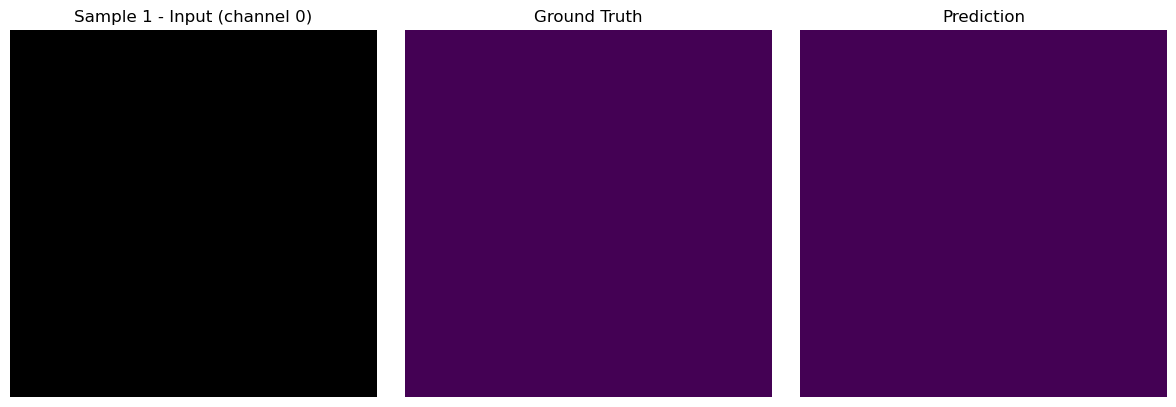

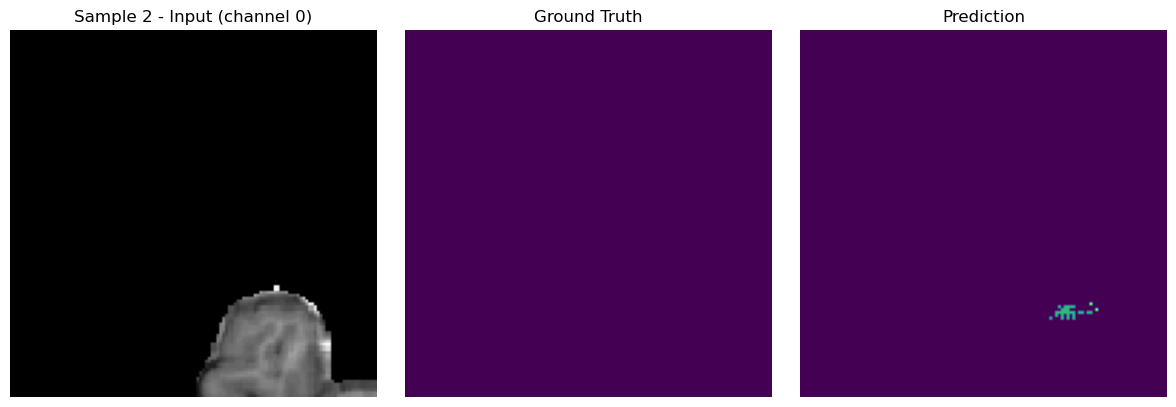

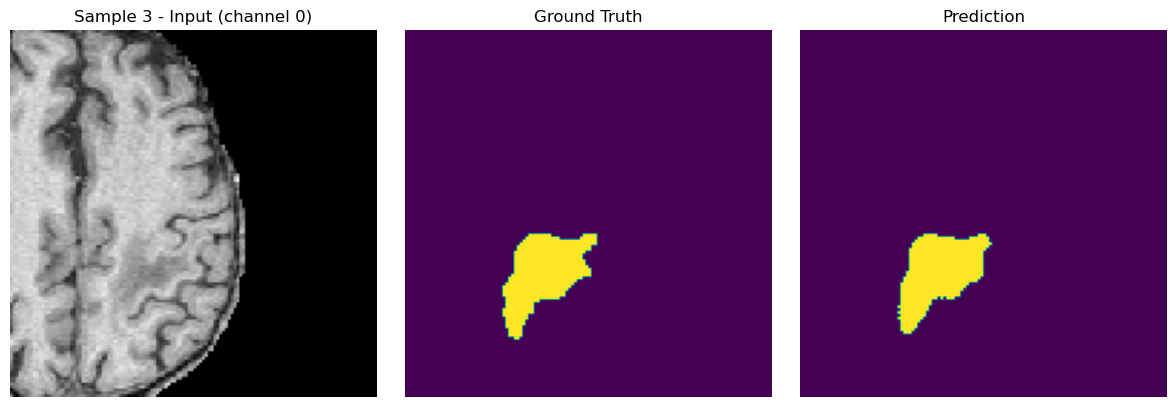

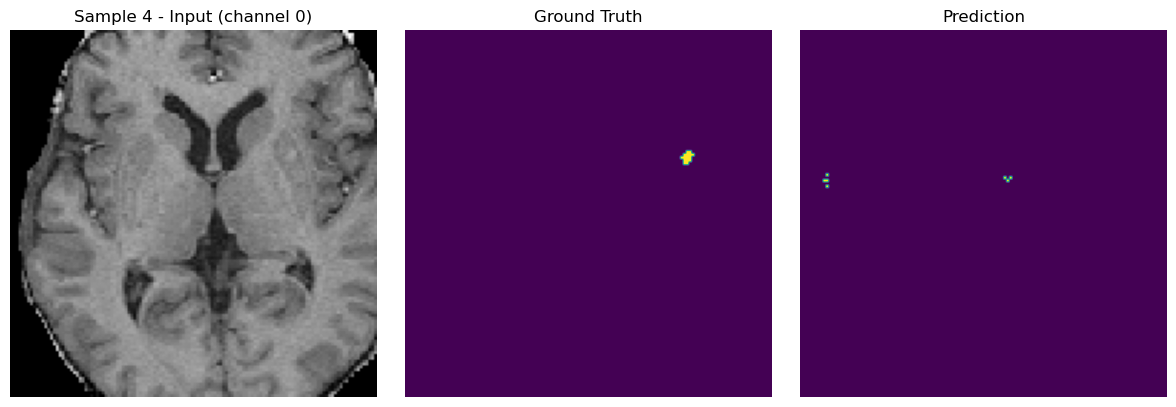

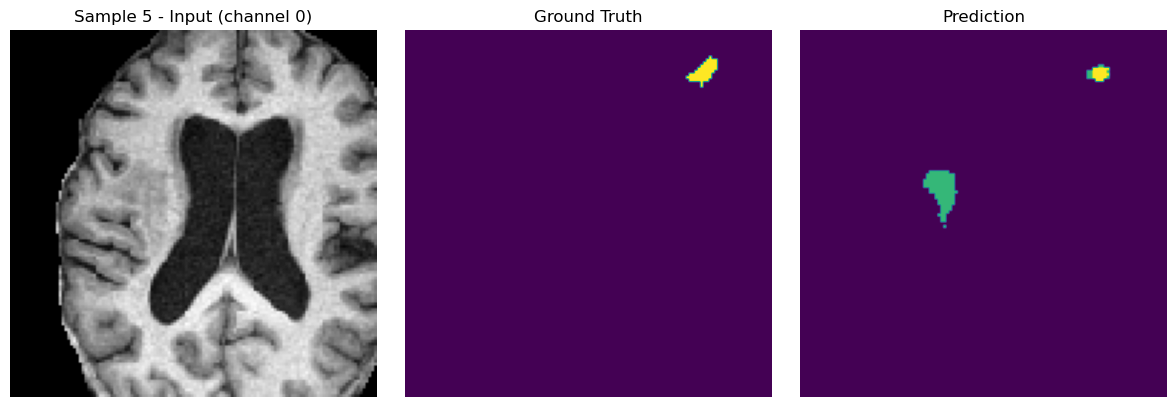

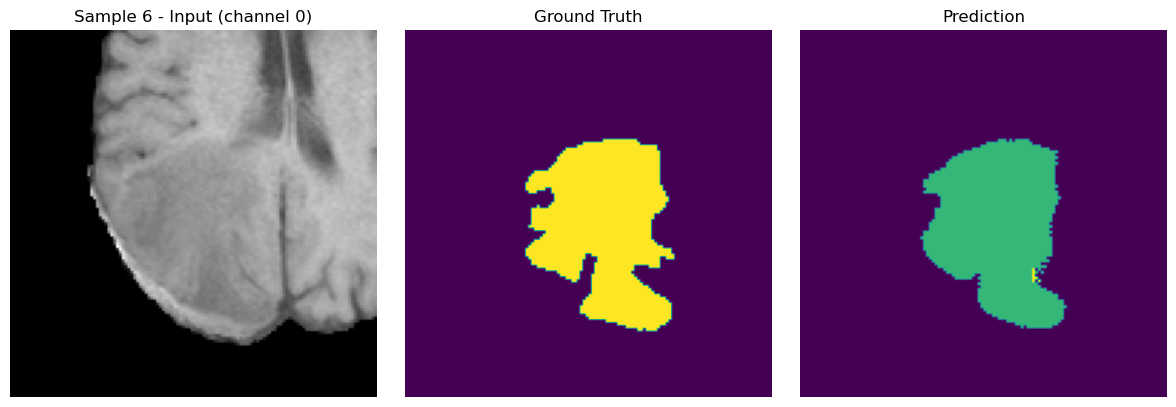

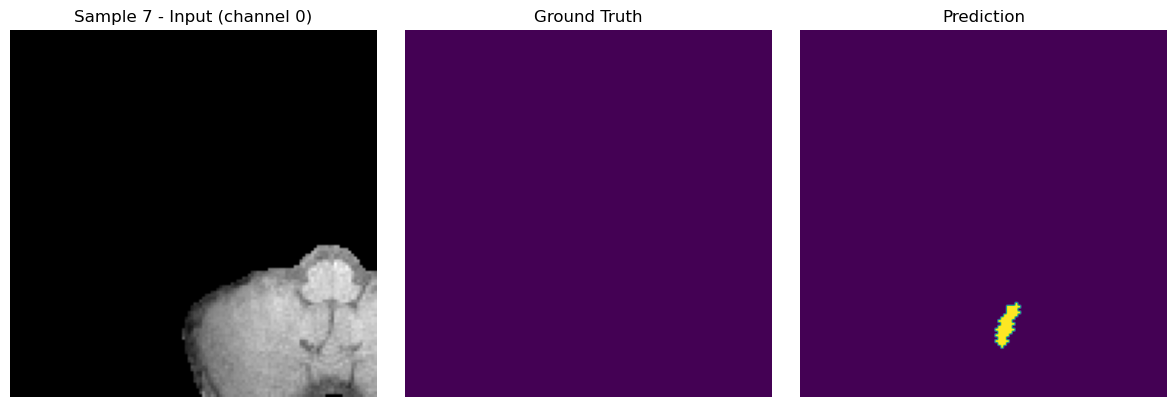

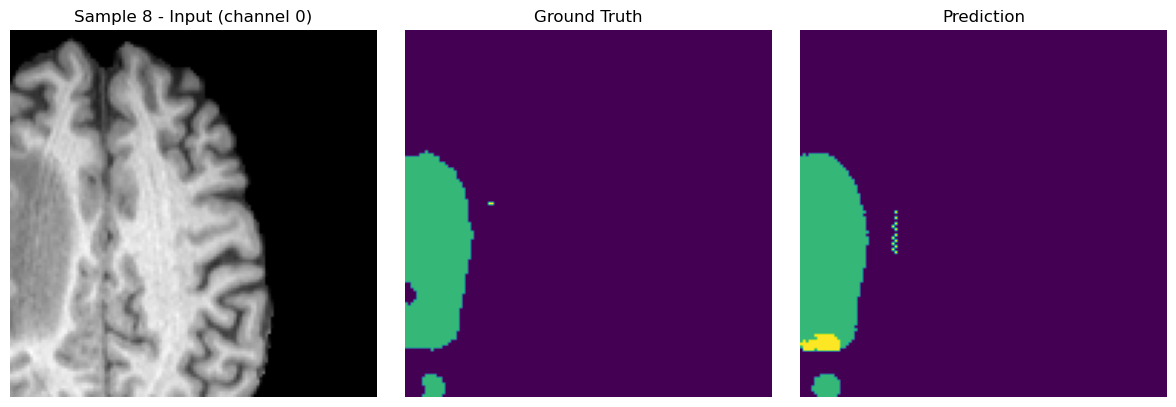

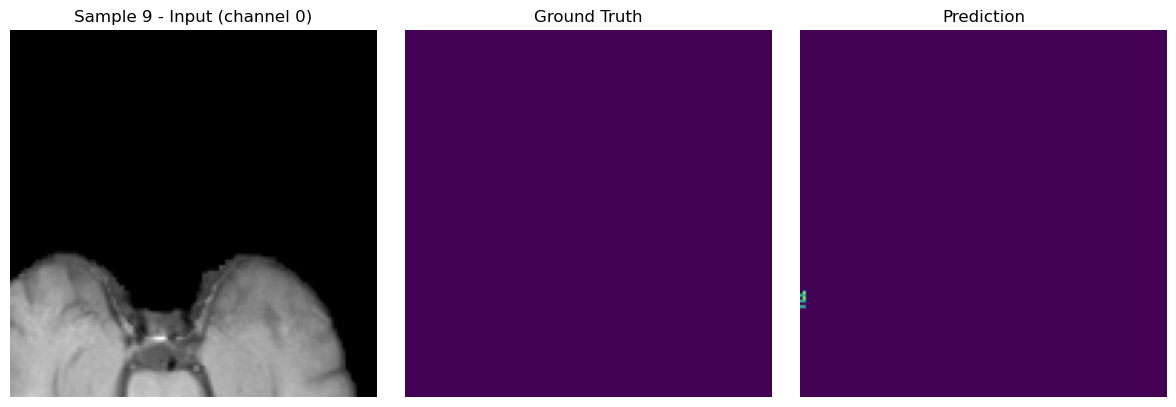

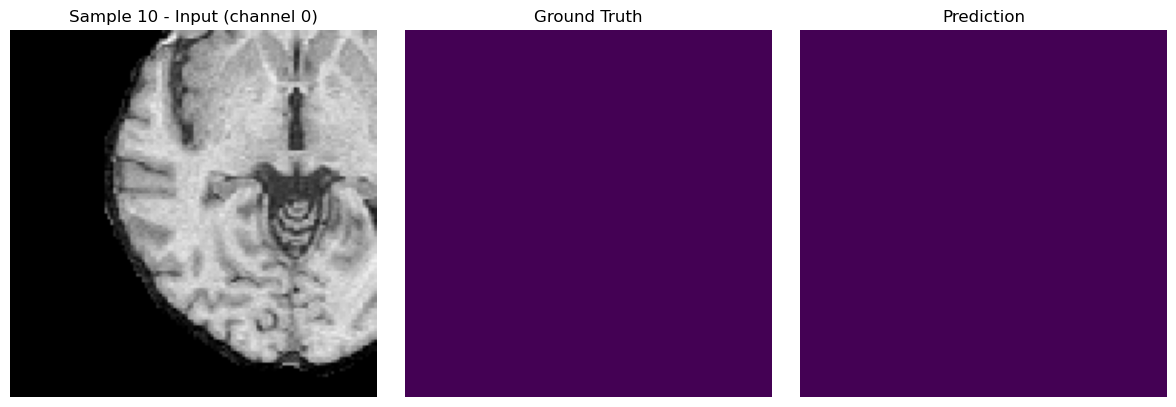

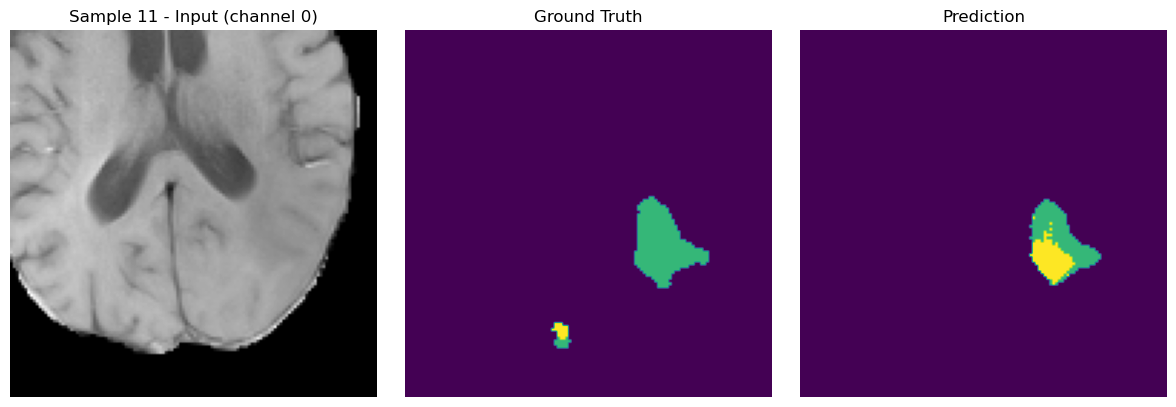

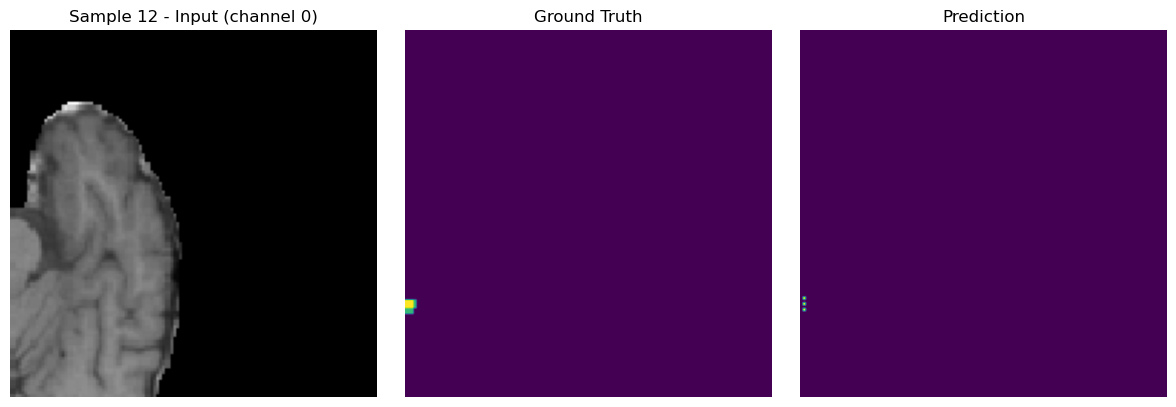

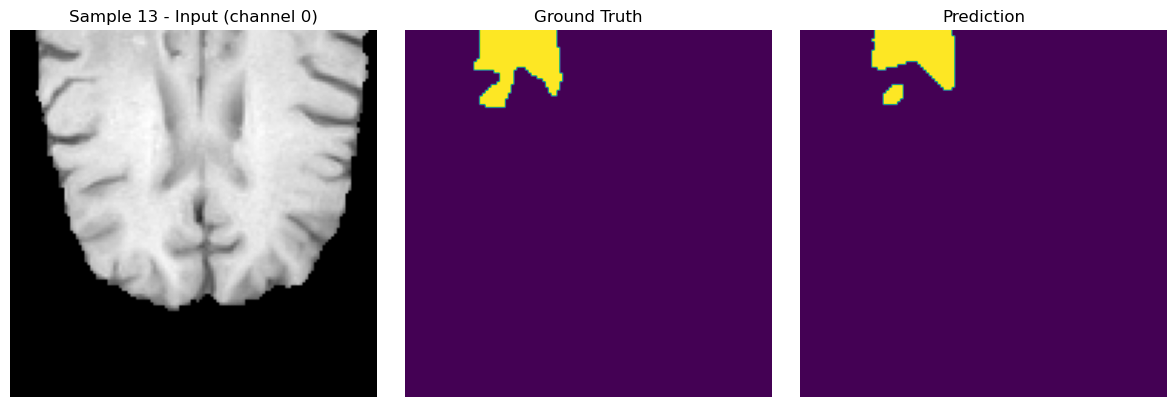

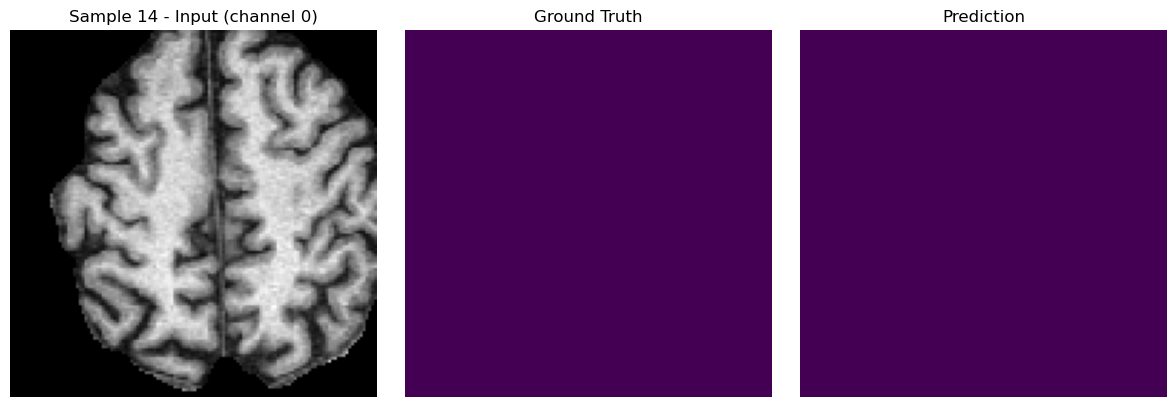

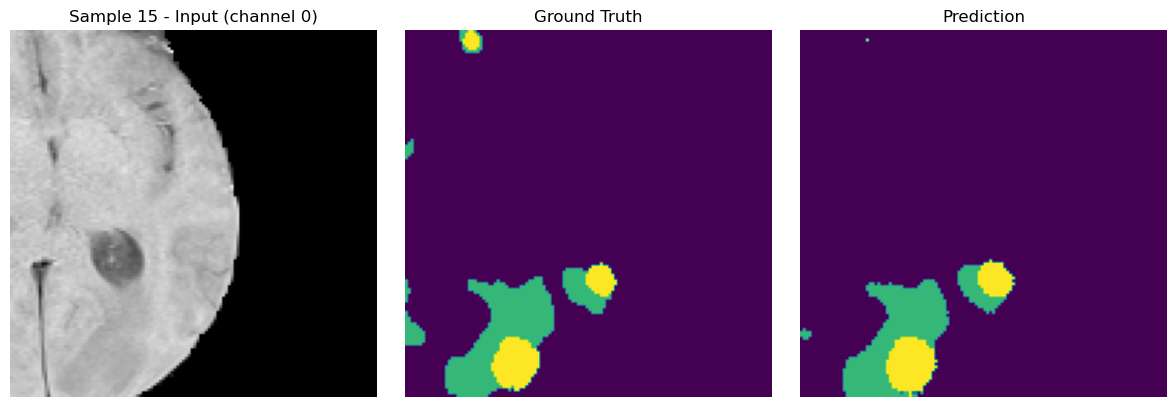

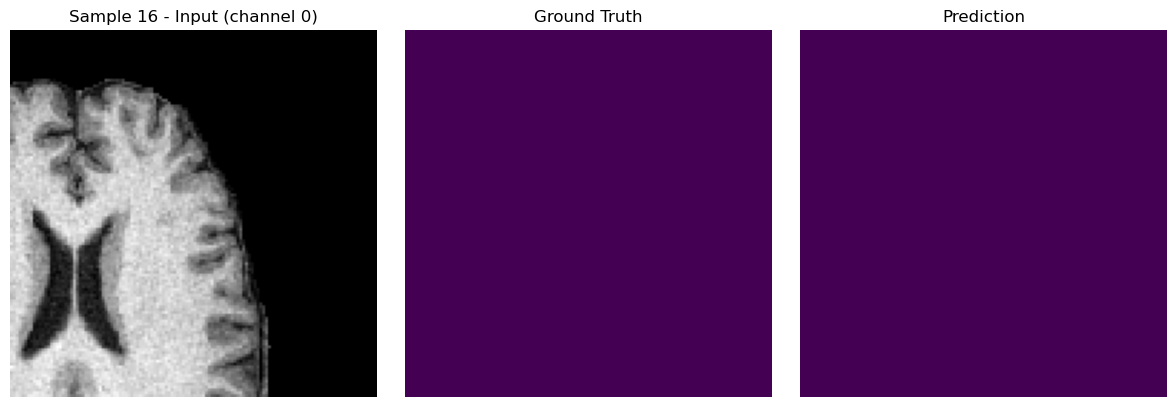

In [17]:
import torch
import matplotlib.pyplot as plt

# 1. Get one batch
inputs, targets = next(iter(validation_dataset))  # [B, C, H, W, D], [B, H, W, D] or [B, 1, H, W, D]
inputs = inputs.to("cuda")
targets = targets.to("cuda")

# 2. Inference
model.eval()
with torch.no_grad():
    logits = model(inputs)                        # [B, C, H, W, D]
    preds = torch.argmax(logits, dim=1)           # [B, H, W, D]

# 3. Loop over batch and plot each sample
batch_size = inputs.shape[0]

for i in range(batch_size):
    input_np = inputs[i, 0].cpu().numpy()  # channel 0 only
    target_np = targets[i].squeeze(0).cpu().numpy() if targets.ndim == 5 else targets[i].cpu().numpy()
    pred_np = preds[i].cpu().numpy()

    z = input_np.shape[2] // 2  # center slice

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(input_np[:, :, z].T, cmap='gray', origin='lower')
    plt.title(f"Sample {i+1} - Input (channel 0)")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(target_np[:, :, z].T, cmap='viridis', origin='lower')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_np[:, :, z].T, cmap='viridis', origin='lower')
    plt.title("Prediction")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [11]:
loaded_model = load_trained_model(
    run_dir="./runs/run_2025-05-12_19-11-47",
    model_class=UNet,
    device='cuda',
    spatial_dims=3,
    in_channels=4,
    out_channels=5,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=2
)

Loading checkpoint: epoch_005.pth


In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def resample_nearest_numpy(volume, input_spacing, target_spacing=(1.0, 1.0, 1.0)):
    input_spacing = np.array(input_spacing)
    target_spacing = np.array(target_spacing)
    zoom_factors = input_spacing / target_spacing

    input_shape = np.array(volume.shape)
    output_shape = np.round(input_shape * zoom_factors).astype(int)

    # Create output grid
    dz = np.linspace(0, input_shape[0] - 1, output_shape[0]).astype(int)
    dy = np.linspace(0, input_shape[1] - 1, output_shape[1]).astype(int)
    dx = np.linspace(0, input_shape[2] - 1, output_shape[2]).astype(int)

    # Meshgrid for indexing
    zz, yy, xx = np.meshgrid(dz, dy, dx, indexing='ij')

    return volume[zz, yy, xx]

# Example usage:

tmp= 'BraTS-MET-00758-000'
path = f"./MICCAI-LH-BraTS2025-MET-Challenge-Training/{tmp}/{tmp}-t1c.nii.gz"

img = nib.load(path)
data = img.get_fdata(dtype=np.float32)
spacing = img.header.get_zooms()[:3]

#print(data.shape)
#print(spacing)

# Resample to (1.0, 1.0, 1.0)
resampled  = resample_nearest_numpy(data, spacing, target_spacing=(1.0, 1.0, 1.0))

print("Original shape:", data.shape)
print("Original spacing:", spacing)
print("Original spacing:", type(spacing))
print("Resampled shape:", resampled.shape)
print("Resampled shape:", type(resampled))

# === Visualize center slice ===
z_orig = data.shape[2] // 2
z_resampled = resampled.shape[2] // 2

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(data[:, :, z_orig].T, cmap="gray", origin="lower")
plt.title(f"Original\nShape: {data.shape}\nSpacing: {spacing}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(resampled[:, :, z_resampled].T, cmap="gray", origin="lower")
plt.title(f"Resampled\nShape: {resampled.shape}\nSpacing: (1.0, 1.0, 1.0)")
plt.axis("off")

plt.tight_layout()
plt.show()